In [370]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from collections import defaultdict
from shapely import speedups
from shapely.geometry import Polygon,Point,mapping
from shapely.affinity import translate


speedups.enable()

In [371]:
# Another good one. I went for shapely to handle the triangles but 
# the gain I get from optimised code is offset by that code being designed for
# the general case. I wrote my own area function to speed up the triangle finding.
# Copying and pasting stackexchange code for the polygon intersections will
# probably speed up the execution.

url='https://www.janestreet.com/puzzles/subtiles//'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:19]))

Place an integer between 1 and 17 into some of the empty cells in the grid. When completed, the grid should have one 1, two 2’s, etc., up to seventeen 17’s. Furthermore, for all N larger than 1, the squares marked N must form a connected N -omino whose shape “contains” the ( N −1)-omino determined by the ( N −1)’s. (Reflections and rotations are allowed.) Some of the cells have already been labeled. The answer to this puzzle is the product of the areas of the empty regions in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/10/20181001_subtiles.png" width="350" >

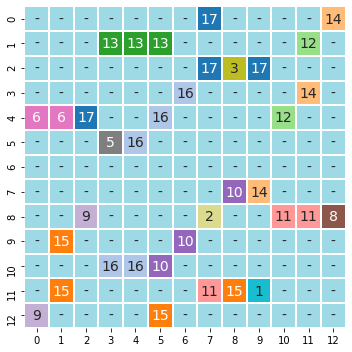

In [283]:
# set up the groups
grid = np.array([[ 0,  0,  0,  0,  0,  0,  0, 17,  0,  0,  0,  0, 14],
                 [ 0,  0,  0, 13, 13, 13,  0,  0,  0,  0,  0, 12,  0],
                 [ 0,  0,  0,  0,  0,  0,  0, 17,  3, 17,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0, 16,  0,  0,  0,  0, 14,  0],
                 [ 6,  6, 17,  0,  0, 16,  0,  0,  0,  0, 12,  0,  0],
                 [ 0,  0,  0,  5, 16,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, 10, 14,  0,  0,  0],
                 [ 0,  0,  9,  0,  0,  0,  0,  2,  0,  0, 11, 11,  8],
                 [ 0, 15,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0, 16, 16, 10,  0,  0,  0,  0,  0,  0,  0],
                 [ 0, 15,  0,  0,  0,  0,  0, 11, 15,  1,  0,  0,  0],
                 [ 9,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0]],dtype=int)

def grid_print(grid):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((grid).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(grid,annot=x,cbar=False,cmap="tab20_r",fmt="",linewidths=1,ax=ax,annot_kws={"size":14})

   
    plt.tight_layout()   
    
grid_print(grid)

In [382]:
class Matrix():
    def __init__(self,grid):
        self.grid = grid
        #set up each grid cell as a polygon for the checking
        self.grid_cells = [[Polygon([[i,j],[i+1,j],[i+1,j+1],[i,j+1]]) for i in range(13)] for j in range(13)]
        self.poss_polys=[ [Polygon([[11,9],[12,9],[12,10],[11,10]]),grid,2] ]
        self.area = Polygon([[0,0],[0,13],[13,13],[13,0]]).buffer(1e-14)
        self.solved = []

    
    # find cells fully in each polyomino.
    def cells_in_area(self,poly):
        (row_min,col_min,row_max,col_max) = poly.bounds
        cells = np.zeros((13,13),dtype=int)
        for i in range(int(row_min),int(row_max)):
            for j in range(int(col_min),int(col_max)):
                cells[i,j] = self.grid_cells[i][j].within(poly.buffer(1e-14))
        return cells
    
    #add blocks to the outside of the polygon
    def poss_new_poly(self,poly):
        left,top,right,bot =poly.bounds
        new_polys =[]
        for i in range(int(left-1),int(right+2)):
            for j in range(int(top-1),int(bot+2)):
                box = Polygon([[i,j],[i+1,j],[i+1,j+1],[i,j+1]])
                if not box.within(poly):
                    new_poly = box.union(poly)
                    if new_poly.geom_type == 'Polygon':
                        new_polys.append(new_poly.simplify(0.01))
        return new_polys

    
    def get_possible_placements(self,poly,grid,next_num):
        poss_polys =[]
        for i,j in itertools.product(range(-13,14),range(-13,14)):            
            poss_poly = translate(poly,xoff=i,yoff=j)
            if not poss_poly.within(self.area):
                continue
            cells_inside = self.cells_in_area(poss_poly)
            inside = self.grid[cells_inside==1]
            if  > 0:
                continue
            if next_num in self.grid[cells_inside==0]:
                continue
            poss_polys.append(poss_poly)
        return poss_polys
            
    # main loop to pull it all together
    # find the possible triangles and then send to solve
    # to place
    def solve(self):
        start = time.perf_counter()
        #while len(self.poss_polys) >0:
        [poly,grid,next_num] = self.poss_polys.pop()
        
        new_polys = self.poss_new_poly(poly)
        
        grid_print(grid)
        for i in new_polys:
            print(i)
            plt.plot(*i.exterior.xy[::-1])
        
        valid_polys =[]
        for p in new_polys:
            print(self.get_possible_placements(p,grid,next_num))

        
        end =  time.perf_counter()        
        print("Solution took {:0.6f} seconds".format(end-start))
        
#############################    
# print out the result nicely    


POLYGON ((11 9, 10 9, 10 10, 12 10, 12 9, 11 9))
POLYGON ((12 9, 12 8, 11 8, 11 10, 12 10, 12 9))
POLYGON ((11 10, 11 11, 12 11, 12 9, 11 9, 11 10))
POLYGON ((12 10, 13 10, 13 9, 11 9, 11 10, 12 10))
[]
[]
[]
[]
Solution took 0.458933 seconds

Solved Grid
~~~~~~~~~~~


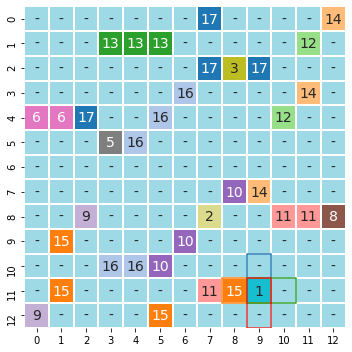

In [383]:
test = Matrix(grid)
test.solve()
print('\nSolved Grid')
print('~~~~~~~~~~~')

In [114]:
url='https://www.janestreet.com/puzzles/solutions/october-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The unique configuration that satisfies the “sub-tiles” property is shown to the left, and the product of the areas of the empty regions is 256 . Congrats to this month’s solvers!


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/11/20181031_subtiles_ans.png" width="350" >

counts = [16  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


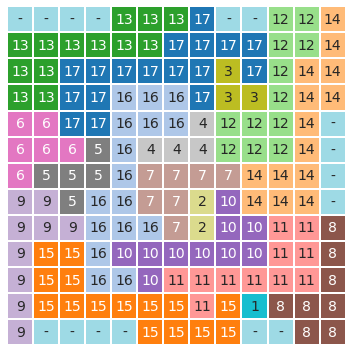

In [118]:
soln = np.array([[ 0,  0,  0,  0, 13, 13, 13, 17,  0,  0, 12, 12, 14],
                 [13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 12, 12, 14],
                 [13, 13, 17, 17, 17, 17, 17, 17,  3, 17, 12, 14, 14],
                 [13, 13, 17, 17, 16, 16, 16, 17,  3,  3, 12, 14, 14],
                 [ 6,  6, 17, 17, 16, 16, 16,  4, 12, 12, 12, 14,  0],
                 [ 6,  6,  6,  5, 16,  4,  4,  4, 12, 12, 12, 14,  0],
                 [ 6,  5,  5,  5, 16,  7,  7,  7,  7, 14, 14, 14,  0],
                 [ 9,  9,  5, 16, 16,  7,  7,  2, 10, 14, 14, 14,  0],
                 [ 9,  9,  9, 16, 16, 16,  7,  2, 10, 10, 11, 11,  8],
                 [ 9, 15, 15, 16, 10, 10, 10, 10, 10, 10, 11, 11,  8],
                 [ 9, 15, 15, 16, 16, 10, 11, 11, 11, 11, 11, 11,  8],
                 [ 9, 15, 15, 15, 15, 15, 15, 11, 15,  1,  8,  8,  8],
                 [ 9,  0,  0,  0,  0, 15, 15, 15, 15,  0,  0,  8,  8]],dtype=int)

grid_print(soln)
print("counts =",np.unique(soln,return_counts=True)[1])


(1.0, 1.0, 2.0, 2.0)
4


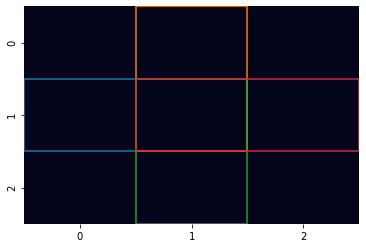

In [199]:
poly= Polygon([[1,1],[1,2],[2,2],[2,1]])
print(poly.bounds)


def poss_new_poly(poly):
    left,top,right,bot =poly.bounds
    new_polys =[]
    for i in range(int(left-1),int(right+1)):
        for j in range(int(top-1),int(bot+1)):
            box = Polygon([[i,j],[i+1,j],[i+1,j+1],[i,j+1]])
            if not box.within(poly):
                new_poly = box.union(poly)
                if new_poly.geom_type == 'Polygon':
                    new_polys.append(new_poly.simplify(0.001))
    return new_polys
                        

x = poss_new_poly(poly)
print(len(x))
sns.heatmap(np.zeros((3,3)),cbar=False)
for i in x:

    plt.plot(*i.exterior.xy)

In [185]:
p1 = Polygon([(0,0),(1,0),(1,1),(0,1)])
p2 = Polygon([(1,0),(1,1),(2,1),(2,0)])
newp = p1.union(p2)
newp.geom_type
newp.geom_type

'Polygon'

True